In [30]:
import multiprocessing as mp
import os
import shutil
import time

import numpy as np
import pandas as pd
import tensorflow_text

from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [31]:
# supress tensorflow warnings and info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [32]:
import tensorflow as tf

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow_hub as hub

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# enables tqdm for pandas
tqdm.pandas()

In [5]:
# load cdp dataset csv as dataframe
df_cdp = pd.read_csv('csvs/cdp_final.csv', sep=',')
df_cdp

,area,title+desc
0,energy efficiency (including public lighting),intensity control of led light points for high...
1,waste management (including waste recycling),installation of tire shredding plant. as a per...
2,transport,environmental monitoring and control of new an...
3,waste management (including waste recycling),strengthening inclusive recycling program. thi...
4,waste management (including waste recycling),waste to energy project for blantyre city. reh...
...,...,...
1300,energy efficiency (including public lighting),decarbonisation of local authority maintained ...
1301,buildings,charlotte & william bloomberg public library. ...
1302,energy efficiency (including public lighting),bloomington green home improvement program. th...
1303,water management,greater amman municipality (gam) - saqef al se...


In [6]:
# load es dataset csv as dataframe
df_es = pd.read_csv('csvs/es_final.csv', sep=',')
df_es

,area,title+desc
0,water management,arroyo medrano restoration in parque saavedra....
1,water management,cildañez stream reservoir activation. the poss...
2,water management,water interpretation center school visits to a...
3,water management,hydraulic adaptation plan to climate change. p...
4,transport,expansion of the bike path network. the work c...
...,...,...
485,outdoor lighting,led lighting. the purpose of changing the ligh...
486,waste management,implementation of the sanitary landfill in the...
487,waste recycling,implementation of selective collection in the ...
488,water management,protection and restoration of springs in the s...


In [7]:
# join two datasets
df_joined = pd.concat([df_cdp, df_es], axis=0) 
df_joined

,area,title+desc
0,energy efficiency (including public lighting),intensity control of led light points for high...
1,waste management (including waste recycling),installation of tire shredding plant. as a per...
2,transport,environmental monitoring and control of new an...
3,waste management (including waste recycling),strengthening inclusive recycling program. thi...
4,waste management (including waste recycling),waste to energy project for blantyre city. reh...
...,...,...
485,outdoor lighting,led lighting. the purpose of changing the ligh...
486,waste management,implementation of the sanitary landfill in the...
487,waste recycling,implementation of selective collection in the ...
488,water management,protection and restoration of springs in the s...


In [8]:
# show sample count for each area (some need to be joined together)
print(pd.DataFrame(df_joined.value_counts(subset='area')).rename(columns={0: 'sample_count'}).to_markdown())

| area                                          |   sample_count |
|:----------------------------------------------|---------------:|
| transport                                     |            347 |
| water management                              |            269 |
| renewable energy                              |            224 |
| waste management (including waste recycling)  |            199 |
| energy efficiency (including public lighting) |            178 |
| buildings                                     |            177 |
| waste management                              |            116 |
| public and green spaces                       |             65 |
| waste recycling                               |             63 |
| energy efficiency / retrofit                  |             50 |
| nature-based solutions                        |             50 |
| outdoor lighting                              |             25 |
| sustainable food consumption/production       |             

In [9]:
# simplify area names
df_corrected = df_joined.copy()

area_energy = (df_corrected['area'] == 'energy efficiency / retrofit') | (df_corrected['area'] == 'energy efficiency (including public lighting)')
df_corrected.loc[area_energy, 'area'] = 'energy effiency'

area_waste = df_corrected['area'] == 'waste management (including waste recycling)'
df_corrected.loc[area_waste, 'area'] = 'waste management'

df_corrected

,area,title+desc
0,energy effiency,intensity control of led light points for high...
1,waste management,installation of tire shredding plant. as a per...
2,transport,environmental monitoring and control of new an...
3,waste management,strengthening inclusive recycling program. thi...
4,waste management,waste to energy project for blantyre city. reh...
...,...,...
485,outdoor lighting,led lighting. the purpose of changing the ligh...
486,waste management,implementation of the sanitary landfill in the...
487,waste recycling,implementation of selective collection in the ...
488,water management,protection and restoration of springs in the s...


In [10]:
# show sample count again
area_count = pd.DataFrame(df_corrected.value_counts(subset='area')).rename(columns={0: 'sample_count'})
print(area_count.to_markdown())

| area                                    |   sample_count |
|:----------------------------------------|---------------:|
| transport                               |            347 |
| waste management                        |            315 |
| water management                        |            269 |
| energy effiency                         |            228 |
| renewable energy                        |            224 |
| buildings                               |            177 |
| public and green spaces                 |             65 |
| waste recycling                         |             63 |
| nature-based solutions                  |             50 |
| outdoor lighting                        |             25 |
| sustainable food consumption/production |             19 |
| land-use                                |             13 |


In [11]:
# remove categories with few samples
min_sample_count = 100
area_count = area_count.rename({0: 'count'}, axis='columns')
areas_to_keep = area_count[area_count > min_sample_count].dropna().index.to_list()
area_filter = df_corrected['area'].isin(areas_to_keep)
df_clean = df_corrected[area_filter]
df_clean

,area,title+desc
0,energy effiency,intensity control of led light points for high...
1,waste management,installation of tire shredding plant. as a per...
2,transport,environmental monitoring and control of new an...
3,waste management,strengthening inclusive recycling program. thi...
4,waste management,waste to energy project for blantyre city. reh...
...,...,...
482,water management,restoration of water basins. it is intended to...
483,energy effiency,sustainable tourism development program in iga...
484,water management,water path. the project provides for the holdi...
486,waste management,implementation of the sanitary landfill in the...


In [12]:
# show new sample count
print(pd.DataFrame(df_clean.value_counts(subset='area')).rename(columns={0: 'sample_count'}).to_markdown())

| area             |   sample_count |
|:-----------------|---------------:|
| transport        |            347 |
| waste management |            315 |
| water management |            269 |
| energy effiency  |            228 |
| renewable energy |            224 |
| buildings        |            177 |


In [13]:
# run the same routine for the untranslated dataset
df_cdp_multi = pd.read_csv('csvs/cdp_clean.csv', sep=',').drop(columns=['Unnamed: 0'])
df_es_multi = pd.read_csv('csvs/es_clean.csv', sep=',').drop(columns=['Unnamed: 0'])
df_joined_multi = pd.concat([df_cdp_multi, df_es_multi], axis=0)[['area', 'title+desc']]

# area_energy = (df_joined_multi['area'] == 'energy efficiency / retrofit') | (df_joined_multi['area'] == 'energy efficiency (including public lighting)')
df_joined_multi.loc[area_energy, 'area'] = 'energy effiency'

# area_waste = df_joined_multi['area'] == 'waste management (including waste recycling)'
df_joined_multi.loc[area_waste, 'area'] = 'waste management'

# min_sample_count = 100
# area_count = area_count.rename({0: 'count'}, axis='columns')
# areas_to_keep = area_count[area_count > min_sample_count].dropna().index.to_list()
area_filter = df_joined_multi['area'].isin(areas_to_keep)
df_clean_multi = df_joined_multi[area_filter]
df_clean_multi

,area,title+desc
0,energy effiency,intensity control of led light points for high...
1,waste management,instalación de planta trituradora de llantas. ...
2,transport,seguimiento y control ambiental a tecnologías ...
3,waste management,fortalecimiento programa de reciclaje inclusiv...
4,waste management,waste to energy project for blantyre city. reh...
...,...,...
482,water management,restauracion de las cuencas de agua. se preten...
483,energy effiency,sustainable tourism development program in iga...
484,water management,caminho das águas. o projeto prevê a a realiza...
486,waste management,implantação do aterro sanitário em forma de co...


In [14]:
param_sets = [
    # model_type, hidden_neurons, epochs
    # ('nnlm50', 0, 24),
    # ('nnlm50', 32, 24),
    # ('nnlm128', 0, 16),
    # ('nnlm128', 64, 16),
    # ('use', 0, 8),
    # ('use', 64, 8),
    # ('use-multi', 0, 8),
    ('use-multi', 64, 20)
]

In [15]:
# selecting the parameters
model_type, hidden_neurons, epochs = param_sets[0]

In [16]:
# x is input, y is output
df_dataset = df_clean_multi if model_type == 'use-multi' else df_clean
x = df_clean_multi['title+desc'].to_numpy()
y = df_clean_multi['area'].to_numpy()

# one hot encode the output
label_binarizer = LabelBinarizer()
y_e = label_binarizer.fit_transform(y)

In [17]:
# split the dataset into train, test and val
x_train, x_valtest, y_train, y_valtest = train_test_split(x, y_e, test_size=0.30, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.5, random_state=42)

In [18]:
# function that implements the model creation, training and deletion
def fit_keras(x_train,
              y_train,
              x_val,
              y_val,
              classes,
              model_type,
              hidden_neurons,
              epochs):
    
    # bring pre-trained model from tf hub as a layer
    if model_type == 'nnlm50':
        model_link = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
    elif model_type == 'nnlm128':
        model_link = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
    elif model_type == 'use':
        model_link = "https://tfhub.dev/google/universal-sentence-encoder/4"
    elif model_type == 'use-multi':
        model_link = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
    hub_layer = hub.KerasLayer(model_link, input_shape=[], dtype=tf.string, trainable=True)

    # create the model with the parameters given
    model = tf.keras.Sequential()
    model.add(hub_layer)
    if hidden_neurons > 0:
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(hidden_neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(classes), activation='softmax'))

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=[tf.metrics.CategoricalAccuracy()])
    
    # enable tensorboard visualizations
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

    # enable early stopping
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # finally, fit the model on the data given
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=[x_val, y_val],
                        verbose=1,
                        callbacks=[tensorboard_callback, early_stopping_callback])

    # return model
    return model, history

In [19]:
# train a model
model, history = fit_keras(x_train=x_train,
                           y_train=y_train,
                           x_val=x_val,
                           y_val=y_val,
                           classes=np.unique(y),
                           model_type=model_type,
                           hidden_neurons=hidden_neurons,
                           epochs=epochs)

2023-03-21 01:13:19.323002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 01:13:19.323546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 01:13:19.323727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 01:13:19.323961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/20


2023-03-21 01:13:44.221854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-21 01:13:44.244109: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f523a018d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-21 01:13:44.244127: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-03-21 01:13:44.247524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-21 01:13:44.341249: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 [==============================] - 90s 1s/step - loss: 1.7117 - categorical_accuracy: 0.4222 - val_loss: 1.5936 - val_categorical_accuracy: 0.6966
Epoch 2/20
35/35 [==============================] - 20s 569ms/step - loss: 1.4879 - categorical_accuracy: 0.7051 - val_loss: 1.3510 - val_categorical_accuracy: 0.7521
Epoch 3/20
35/35 [==============================] - 15s 435ms/step - loss: 1.2549 - categorical_accuracy: 0.7647 - val_loss: 1.1705 - val_categorical_accuracy: 0.7949
Epoch 4/20
35/35 [==============================] - 11s 313ms/step - loss: 1.0696 - categorical_accuracy: 0.8269 - val_loss: 1.0370 - val_categorical_accuracy: 0.8120
Epoch 5/20
35/35 [==============================] - 11s 315ms/step - loss: 0.9340 - categorical_accuracy: 0.8571 - val_loss: 0.9346 - val_categorical_accuracy: 0.8162
Epoch 6/20
35/35 [==============================] - 9s 264ms/step - loss: 0.8047 - categorical_accuracy: 0.8919 - val_loss: 0.8430 - val_categorical_accuracy: 0.8248
Epoch 7/20
35

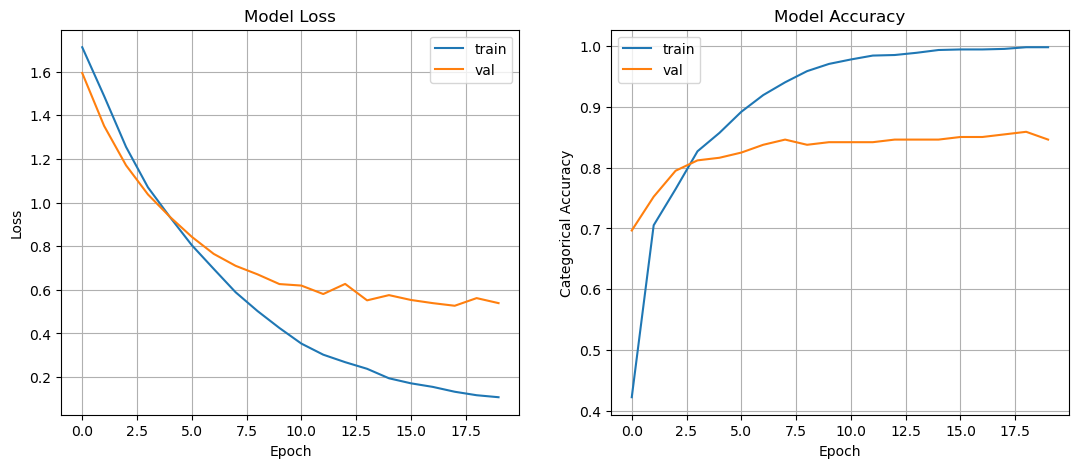

In [39]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(13, 5))

ax_loss.plot(history.history['loss'])
ax_loss.plot(history.history['val_loss'])
ax_loss.set_title('Model Loss')
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.legend(['train', 'val'])
ax_loss.grid()

ax_acc.plot(history.history['categorical_accuracy'])
ax_acc.plot(history.history['val_categorical_accuracy'])
ax_acc.set_title('Model Accuracy')
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Categorical Accuracy')
ax_acc.legend(['train', 'val'])
ax_acc.grid()

In [40]:
# get train accuracy
train_loss, train_acc = model.evaluate(x_train, y_train, batch_size=32)
train_acc

35/35 [==============================] - 1s 16ms/step - loss: 0.0831 - categorical_accuracy: 0.9982


0.9981684684753418

In [41]:
# get val accuracy
val_loss, val_acc = model.evaluate(x_val, y_val, batch_size=32)
val_acc

8/8 [==============================] - 0s 14ms/step - loss: 0.5390 - categorical_accuracy: 0.8462


0.8461538553237915

In [42]:
# get test accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=32)
test_acc

8/8 [==============================] - 0s 17ms/step - loss: 0.6008 - categorical_accuracy: 0.7949


0.7948718070983887

In [23]:
p = model.count_params()
print(f'{p/1e6:.2f} · 10^6')

68.96 · 10^6


In [43]:
# put accuracy results on a table
df_acc = pd.DataFrame({'train': [train_acc], 'val': [val_acc], 'test': [test_acc]}, index=['acc']).T
df_acc

,acc
train,0.998168
val,0.846154
test,0.794872


In [44]:
# print table
print(df_acc.apply(lambda r: f'{r["acc"]:.4f}', axis=1).to_markdown())

|       |      0 |
|:------|-------:|
| train | 0.9982 |
| val   | 0.8462 |
| test  | 0.7949 |


In [26]:
# save model
model.save('models/trained_model.h5')

8/8 [==============================] - 1s 15ms/step


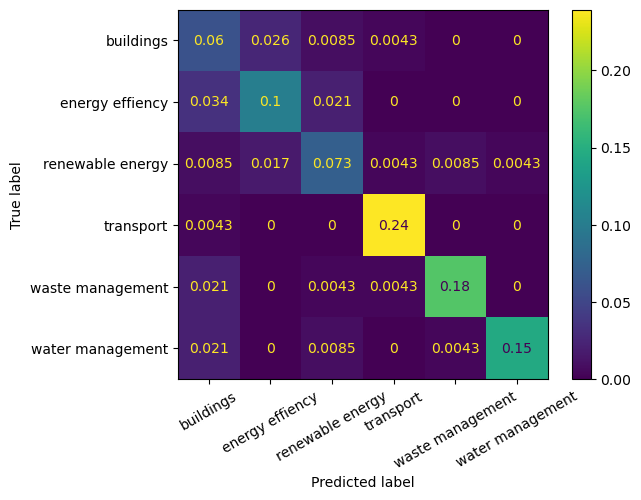

In [27]:
# confusion matrix
y_true = label_binarizer.inverse_transform(y_test)
y_pred = label_binarizer.inverse_transform(model.predict(x_test))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='all', xticks_rotation=30)

In [28]:
label_binarizer.inverse_transform(model.predict(np.array([
    'solar wind farm on the netherlands creating sustainable energy for a small town',
    'sistema de tratamento de esgoto em torno da periferia'
])))

1/1 [==============================] - 0s 20ms/step


array(['renewable energy', 'waste management'], dtype='<U16')